# Laflamme Code with Braunstein Improvement
This notebook demonstrates a quantum error correction simulation using the Laflamme code with Braunstein's improvement. The focus is on simulating the evolution of a logical qubit using the stochastic master equation, showcasing how quantum error correction protects the state over time.


## Importing Required Libraries
Here, we import `numpy` for numerical computations, `qutip` for quantum mechanics functions, and `matplotlib` for plotting.


In [111]:
import numpy as np
from qutip import *
from qutip.qip.operations import hadamard_transform, z_gate, x_gate
import matplotlib.pyplot as plt
import itertools

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 2. Defining Quantum Gates and Operators for Error Correction
To simulate the Laflamme code, we need to define quantum operators for each qubit in our 5-qubit system.
### 2.1 Spin Operators
To model each spin in our 5-qubit system, we define `x`, `y`, and `z` Pauli operators for each spin (or qubit). These operators are crucial for constructing the Hamiltonian, applying quantum gates, and modeling interactions and measurements in the system.

- `x_spin_1` through `x_spin_5`: X operators for each spin.
- `y_spin_1` through `y_spin_5`: Y operators for each spin.
- `z_spin_1` through `z_spin_5`: Z operators for each spin.

In [58]:
# Number of qubits in the system
n_qubits = 5
spin_levels = 2  # Each qubit has 2 levels

# Identity operator for a single qubit
I = qeye(spin_levels)

# Define spin operators for each qubit
# Each operator acts on its respective qubit, with identity matrices for the others

# Spin operators for qubits 1 to 5
x_spin = []
y_spin = []
z_spin = []

for i in range(n_qubits):
    op_list = [I] * n_qubits
    op_list[i] = sigmax() / 2
    x_spin.append(tensor(op_list))
    
    op_list[i] = sigmay() / 2
    y_spin.append(tensor(op_list))
    
    op_list[i] = sigmaz() / 2
    z_spin.append(tensor(op_list))

## Initializing the System State and Hamiltonian
We initialize the logical qubit's starting state and define the Hamiltonian of the system.

### Initial State (psi_0)

We initialize the original qubit in a superposition ∣0⟩ + ∣1⟩ and all anchilla qubits in the ground state ∣0⟩:

In [176]:
psi_0 = tensor(
    basis(spin_levels, 1),  # Qubit 1
    basis(spin_levels, 0),  # Qubit 2
    basis(spin_levels, 0),  # Qubit 3
    basis(spin_levels, 0),  # Qubit 4
    basis(spin_levels, 0)   # Qubit 5
)

Convert the state vector to a density matrix and normalize:

In [177]:
rho_0 = ket2dm(psi_0)
rho_0 /= rho_0.tr()

### Hamiltonian (H)

We set the system Hamiltonian to zero to focus on environmental damping and dephasing effects:

In [178]:
H = 0 * x_spin[0]  # Zero Hamiltonian

## Measurement Strengths and Operators

We define the measurement strengths and operators to simulate environmental damping and dephasing.

### Measurement Damping Parameters

- `damping_rate`: Represents isotropic weak damping applied uniformly to all qubits.
- `measurement_strength`: Represents measurement stregh for the readout of the measurement quibt. Is setmuch higher than the readout duration to ensure wavefunction collaps.

In [206]:
measurement_strength = 1
damping_rate = 0.0001

### Collapse Operators (c_ops)

We define collapse operators for each qubit's $x$, $y$, and $z$ directions:

In [207]:
c_measure_strength = {}
c_ops = {}

for i in range(n_qubits):
    c_measure_strength[f'spin_{i+1}_x_damping'] = np.sqrt(damping_rate)
    c_ops[f'spin_{i+1}_x_damping'] = x_spin[i]
    
    c_measure_strength[f'spin_{i+1}_y_damping'] = np.sqrt(damping_rate)
    c_ops[f'spin_{i+1}_y_damping'] = y_spin[i]
    
    c_measure_strength[f'spin_{i+1}_z_damping'] = np.sqrt(damping_rate)
    c_ops[f'spin_{i+1}_z_damping'] = z_spin[i]

### Stochastic Measurement Operators (sc_ops)

Set up for the strong measurement of the measurement qubits:

In [208]:
sc_measure_strength = {}
sc_ops = {}

for i in range(n_qubits):
    sc_measure_strength[f'spin_{i+1}_z_damping'] = measurement_strength
    sc_ops[f'spin_{i+1}_z_damping'] = z_spin[i]

### Expectation Operators (e_ops)

Used for visualization of the $z$-component of each spin:

In [209]:
e_ops = {f'z_spin_{i+1}': z_spin[i] for i in range(n_qubits)}

# Initialize arrays to store expectation values and time
all_expect = {f'z_spin_{i+1}': np.array([]) for i in range(n_qubits)}
all_t = np.array([])

## Encoding and Decoding Functions
We define functions to encode and decode the logical qubit using the Laflamme code.
### Defining Logical Gates and Encoding Steps
The encoding process involves a specific sequence of quantum gates:


In [210]:
encoding = []

# Define the unitary operator U
U = Qobj(np.array([[1, -1], [1, 1]]) / np.sqrt(2))

# Step 1: Apply U† to Qubit 2
encoding.append(tensor(I, U.dag(), I, I, I))

# Step 2: Apply CNOT gates with Qubit 2 as control
encoding.append(qip.operations.cnot(N=5, control=1, target=2))  # Qubit 2 -> Qubit 3
encoding.append(qip.operations.cnot(N=5, control=1, target=3))  # Qubit 2 -> Qubit 4

# Step 3: Apply U to Qubit 2
encoding.append(tensor(I, U, I, I, I))

# Step 4: Apply CNOT with Qubit 3 as control to Qubit 5
encoding.append(qip.operations.cnot(N=5, control=1, target=4))

# Step 5: Apply CNOT gates with Qubit 1 as control
encoding.append(qip.operations.cnot(N=5, control=0, target=1))  # Qubit 1 -> Qubit 2
encoding.append(qip.operations.cnot(N=5, control=0, target=2))  # Qubit 1 -> Qubit 3

# Step 6: Apply U to Qubit 1
encoding.append(tensor(U, I, I, I, I))

# Step 7: Apply CNOT gates with Qubit 1 as control
encoding.append(qip.operations.cnot(N=5, control=0, target=3))  # Qubit 1 -> Qubit 4
encoding.append(qip.operations.cnot(N=5, control=0, target=4))  # Qubit 1 -> Qubit 5

### Encoding and Decoding Functions

In [211]:
def encode(psi):
    for gate in encoding:
        psi = gate * psi
    return psi

def decode(psi):
    for gate in encoding[::-1]:
        psi = gate.dag() * psi
    return psi

## Error Correction Procedure
We simulate errors and define a correction table to map syndromes to correction operations.
### Defining Possible Errors and Correction Table

We define single-qubit errors and combinations (bit flip (B), phase flip (P)):


In [212]:
errors = {'none': tensor([I]*n_qubits)}

# Bit-flip errors (X)
for i in range(n_qubits):
    error_op = [I]*n_qubits
    error_op[i] = x_gate()
    errors[f'B{i}'] = tensor(error_op)

# Phase-flip errors (Z)
for i in range(n_qubits):
    error_op = [I]*n_qubits
    error_op[i] = z_gate()
    errors[f'P{i}'] = tensor(error_op)

# Combined errors (X and Z)
for i in range(n_qubits):
    error_op = [I]*n_qubits
    error_op[i] = x_gate() * z_gate()
    errors[f'BP{i}'] = tensor(error_op)

errors.keys()

dict_keys(['none', 'B0', 'B1', 'B2', 'B3', 'B4', 'P0', 'P1', 'P2', 'P3', 'P4', 'BP0', 'BP1', 'BP2', 'BP3', 'BP4'])

### Correction Table

A corection table is generated by encoding a state `psi_0` that is uniquely mapped to some corrupted state after the application of an error. This way, from each syndrom measurement ouput the corresponding correction operation can be found. We apply each error to the encoded state, decode it, and determine the correction needed based on the syndrome.

In [213]:
psi_0 = tensor(2*basis(spin_levels, 0)+1*basis(spin_levels, 1), basis(spin_levels, 0), basis(spin_levels, 0), basis(spin_levels, 0), basis(spin_levels, 0))
psi_0 /= psi_0.norm()

psi_enc = encode(psi_0)
correction_table = {}

def generate_all_states(N):
    return list(itertools.product([0, 1], repeat=N))

def ket_5(a, b, c, d, e):
    return tensor(basis(spin_levels, a), basis(spin_levels, b), basis(spin_levels, c), basis(spin_levels, d), basis(spin_levels, e))

def find_state(psi):
    all_states = generate_all_states(5)
    overlap_out = []
    states_out = []
    
    for state in all_states:
        overlap = ket_5(*state).dag() * psi
        if not overlap.full()==0:
            #print('overlap:', overlap.full(), state)
            overlap_out.append(overlap.full()[0,0])
            states_out.append(state)
    return overlap_out, states_out


for key in errors.keys():
    
    # encode, produce error, decode
    psi_err = errors[key] * psi_enc
    psi_dec = decode(psi_err)

    # find states after decoding
    overlaps, states = find_state(psi_dec)
    
    # find state of psi after measurement
    coefs = []
    for i in range(2):
        if overlaps[i] > 0.6:
            coefs.append('a')
        elif overlaps[i] < 0.6 and overlaps[i] > 0:
            coefs.append('b')
        elif overlaps[i] < 0 and overlaps[i] > -0.6:
            coefs.append('-b')
        elif overlaps[i] < -0.6:
            coefs.append('-a')
    
    # find error correcting operation
    correct_op = []
    if '-' in coefs[1]:
        correct_op.append('Z')
    if 'a' in coefs[1]:
        correct_op.append('X')
    if '-' in coefs[0]:
        correct_op.append('Z')
    correct_op = correct_op[::-1]   
    
    correction_table[str(states[0][1])+str(states[0][2])+str(states[0][3])+str(states[0][4])] = correct_op
        
    print('Error: ', key, '--> Syndom', str(states[0][1:]), 'Resulting state: ', coefs[0], '|0> + ', coefs[1], '|1>, Correction: ', correct_op)


Error:  none --> Syndom (0, 0, 0, 0) Resulting state:  a |0> +  b |1>, Correction:  []
Error:  B0 --> Syndom (0, 0, 1, 1) Resulting state:  a |0> +  -b |1>, Correction:  ['Z']
Error:  B1 --> Syndom (1, 0, 0, 1) Resulting state:  a |0> +  b |1>, Correction:  []
Error:  B2 --> Syndom (0, 1, 0, 0) Resulting state:  a |0> +  b |1>, Correction:  []
Error:  B3 --> Syndom (0, 0, 1, 0) Resulting state:  a |0> +  b |1>, Correction:  []
Error:  B4 --> Syndom (0, 0, 0, 1) Resulting state:  a |0> +  b |1>, Correction:  []
Error:  P0 --> Syndom (1, 1, 0, 1) Resulting state:  -b |0> +  -a |1>, Correction:  ['Z', 'X', 'Z']
Error:  P1 --> Syndom (0, 1, 1, 0) Resulting state:  a |0> +  -b |1>, Correction:  ['Z']
Error:  P2 --> Syndom (1, 0, 0, 0) Resulting state:  a |0> +  -b |1>, Correction:  ['Z']
Error:  P3 --> Syndom (0, 1, 0, 1) Resulting state:  -b |0> +  -a |1>, Correction:  ['Z', 'X', 'Z']
Error:  P4 --> Syndom (1, 0, 1, 1) Resulting state:  -b |0> +  -a |1>, Correction:  ['Z', 'X', 'Z']
Error:

## 7. Evolution of the System
We define functions to simulate the system’s evolution over time (`free_evo`) and store the results for visualization. These functions allow us to monitor the fidelity of the logical qubit state over time.

### 7.1 System Evolution and Stochastic Master Equation
The `free_evo()` function runs the evolution using the stochastic master equation to account for damping and measurement noise.

### 7.2 Plotting Fidelity and Expectation Values
Using `plt_result()`, we plot the results to observe how the fidelity and individual qubit states evolve over time.

- `free_evo()`: Main function simulating time evolution.
- `plt_result()`: Plots fidelity and expectation values over time.


In [214]:
def free_evo(rho, t):

    c_ops_m = [c_measure_strength[op] * c_ops[op] for op in c_ops]
    sc_ops_m = [sc_measure_strength[op] * sc_ops[op] for op in sc_ops]
    opts = Options(store_states=True, store_final_state=True)

    result = mesolve(H, rho, t, c_ops=c_ops_m, e_ops=e_ops,
                               options=opts)
    
    return result

def store_result(all_t, all_expect, t, result):

    for i in range(n_qubits):
         all_expect[f'z_spin_{i+1}'] = np.hstack([all_expect[f'z_spin_{i+1}'], result.expect[f'z_spin_{i+1}']])
            
    all_t = np.hstack([all_t, t])
    
    return all_t, all_expect
def plt_result(all_t, all_expect, all_rho, all_rho_test, psi_0, t_stop, n_steps):

    # Create subplots
    fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

    # Time array
    time = np.linspace(0, len(all_t) * t_stop / n_steps, len(all_t))

    # Extract expectation values
    values = list(all_expect.values())

    # Define colors for the qubits
    colors = plt.cm.viridis(np.linspace(0, 1, 5))

    # Plot all 5 qubits in one plot
    for i in range(5):
        ax[0].plot(time, values[i], label=f'Qubit {i + 1}', color=colors[i], linewidth=2)

    # Add faint vertical lines for multiples of 20 in time
    for t_val in time:
        if t_val % 20 < (t_stop / n_steps):  # Check for multiples of 20 with a tolerance
            ax[0].axvline(x=t_val, color='gray', linestyle='--', linewidth=0.5)
            ax[1].axvline(x=t_val, color='gray', linestyle='--', linewidth=0.5)

    # Calculate fidelity
    fidelity = [
        np.real(np.sqrt((psi_0.dag() * rho * psi_0).full())).flatten()[0]
        for rho in all_rho
    ]
    fidelity_test = [
        np.real(np.sqrt((psi_0.dag() * rho * psi_0).full())).flatten()[0]
        for rho in all_rho_test
    ]

    # Plot fidelity comparisons
    ax[1].plot(time, fidelity, label='Fidelity (error corrected)', color='blue', linewidth=2)
    ax[1].plot(
        time, fidelity_test, label='Fidelity (uncorrected)', color='red', linestyle='--', linewidth=2
    )

    # Customize the first subplot
    ax[0].set_title('Evolution of 5 Qubits')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Expectation Value (z direction)')
    ax[0].legend()
    ax[0].grid(True)

    # Customize the second subplot
    ax[1].set_title('Fidelity Comparison')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Fidelity')
    ax[1].legend()
    ax[1].grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    
def dens_op(op, rho):
    return vector_to_operator(to_super(op)*operator_to_vector(rho))

def encoder(rho, all_t, all_expect, all_rho, rho_0):
    result = free_evo(rho, t)
    all_t, all_expect = store_result(all_t, all_expect, t, result)
    if len(all_rho) == 0:
        all_rho = result.states
    else:
        all_rho += result.states
    rho = result.final_state
    
        
    for gate in encoding:
        rho = dens_op(gate, rho)
        
        result = free_evo(rho, t)
        all_t, all_expect = store_result(all_t, all_expect, t, result)
        rho = result.final_state
        all_rho += result.states

    return rho, all_t, all_expect, all_rho

def decoder(rho, all_t, all_expect, all_rho, rho_0):
    for gate in encoding[::-1]:
        rho = dens_op(gate.dag(), rho)
        
        result = free_evo(rho, t)
        all_t, all_expect = store_result(all_t, all_expect, t, result)
        rho = result.final_state
        all_rho += result.states
        
    return rho, all_t, all_expect, all_rho

## 8. Running the Full Simulation
### 8.1 Encoding-Decoding Cycles with Error Correction
The final part of the notebook runs a full simulation by iterating over encoding, error correction, and decoding cycles. After each cycle, it applies corrections based on the syndrome measurement.

- `encoder(rho, all_t, all_expect, all_rho)`: Runs the encoding and free evolution.
- `decoder(rho, all_t, all_expect, all_rho)`: Runs the decoding and free evolution.
- `plt_result()`: Displays the results over 20 cycles to assess the effectiveness of error correction.

Run the simulation below to observe how the Laflamme code mitigates errors over time.

In [215]:
# each free evolution is take to be 15 timesteps

t_start = 0
t_stop = 2e1
n_steps = int(2e2)
t = np.linspace(t_start, t_stop, n_steps)

Total run time:   0.16s
syndrom measurement: 0000 applied correction: []


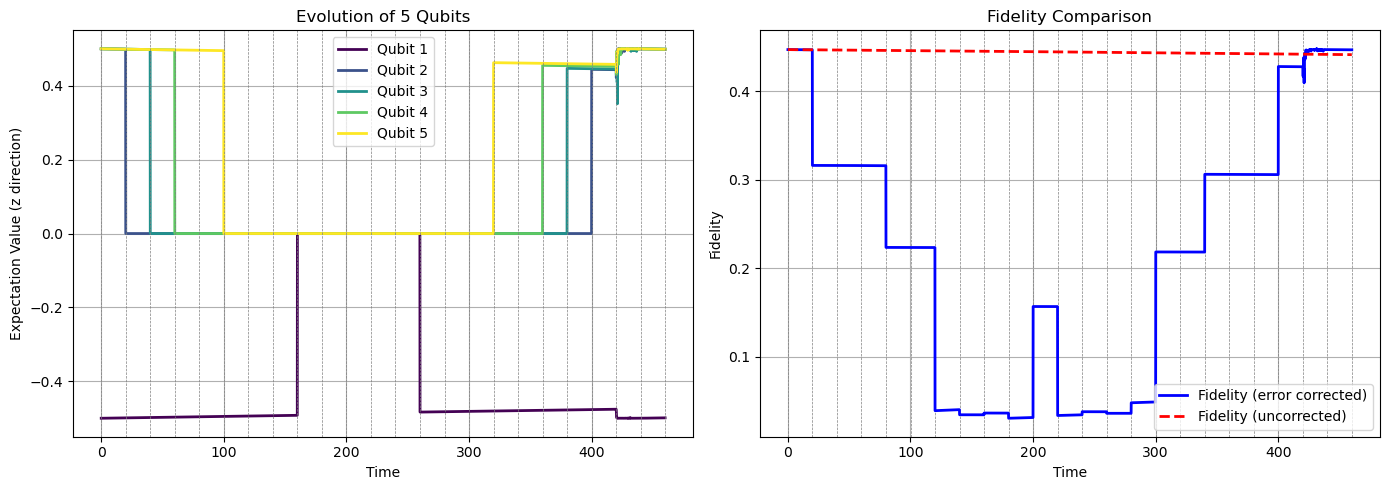

Total run time:   0.14s
syndrom measurement: 0000 applied correction: []


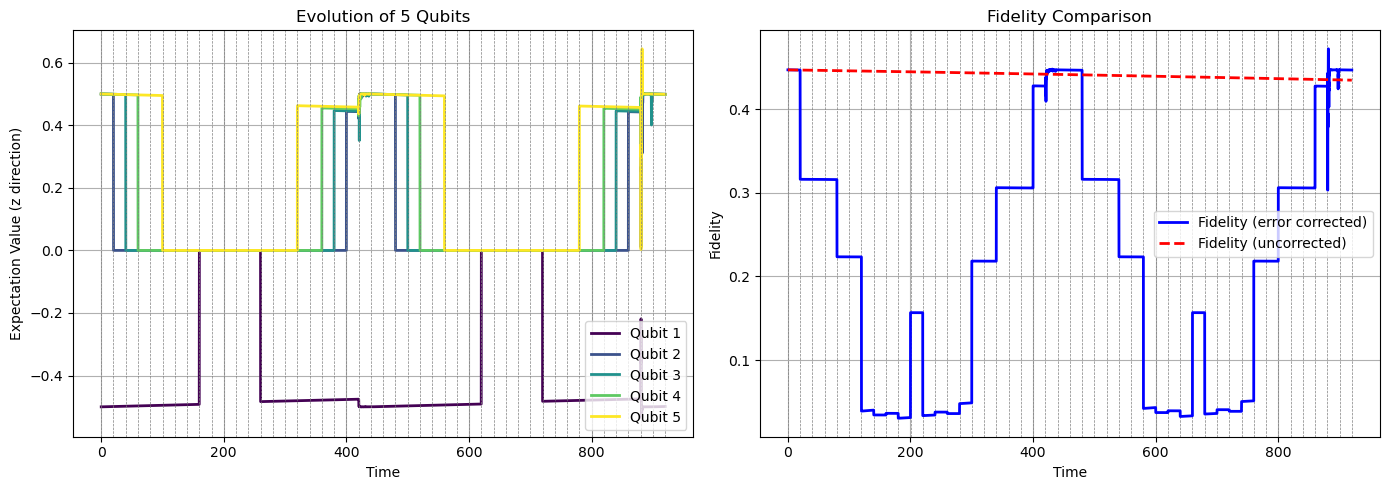

Total run time:   0.14s
syndrom measurement: 0000 applied correction: []


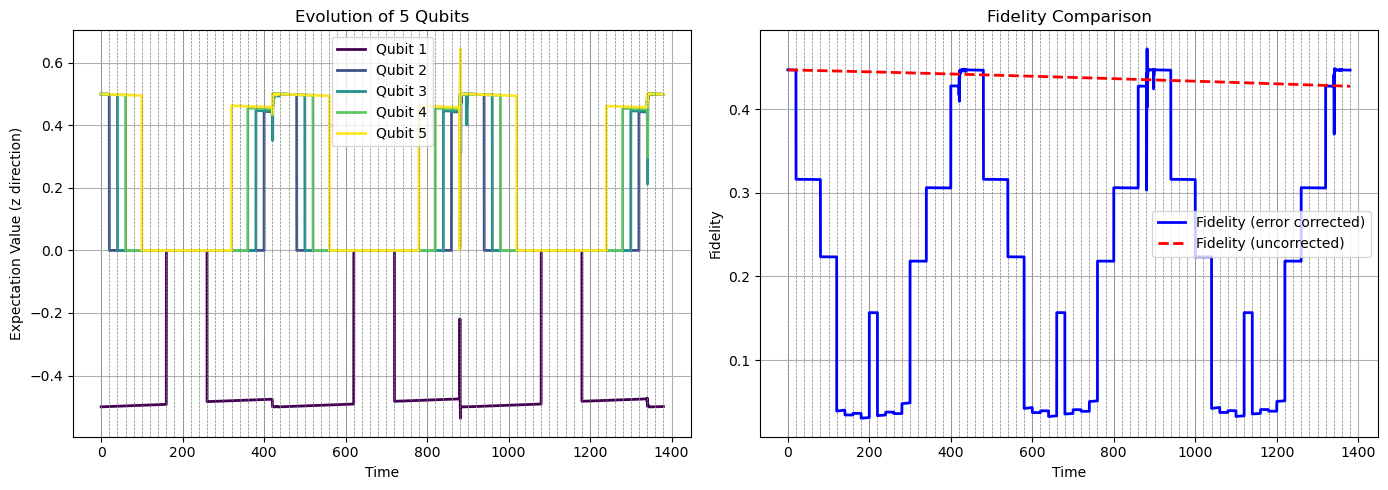

Total run time:   0.15s
syndrom measurement: 0000 applied correction: []


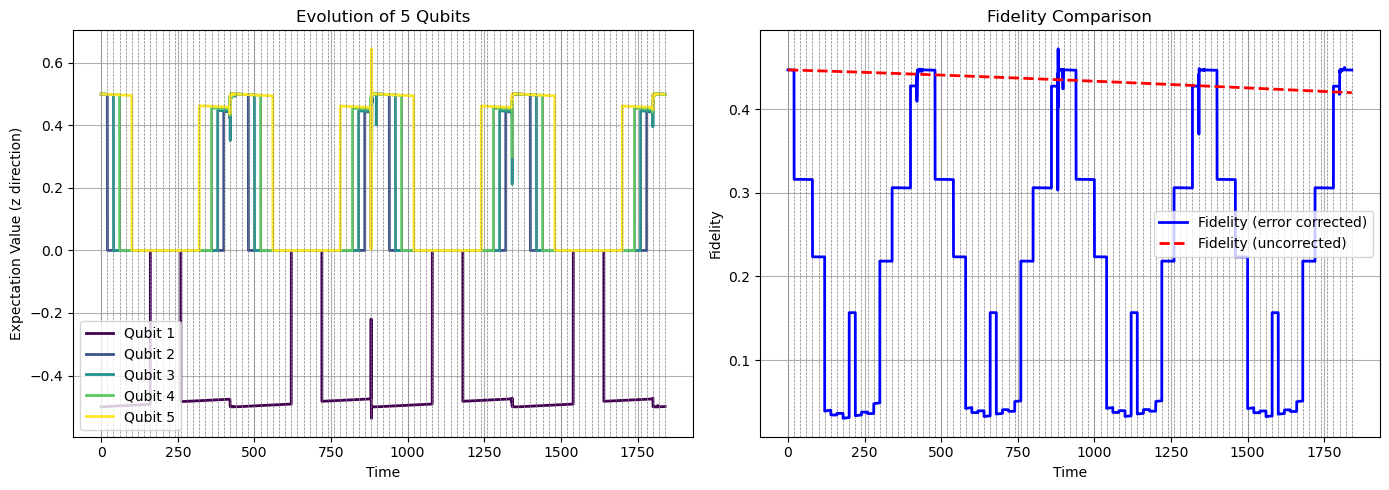

Total run time:   0.14s
syndrom measurement: 0000 applied correction: []


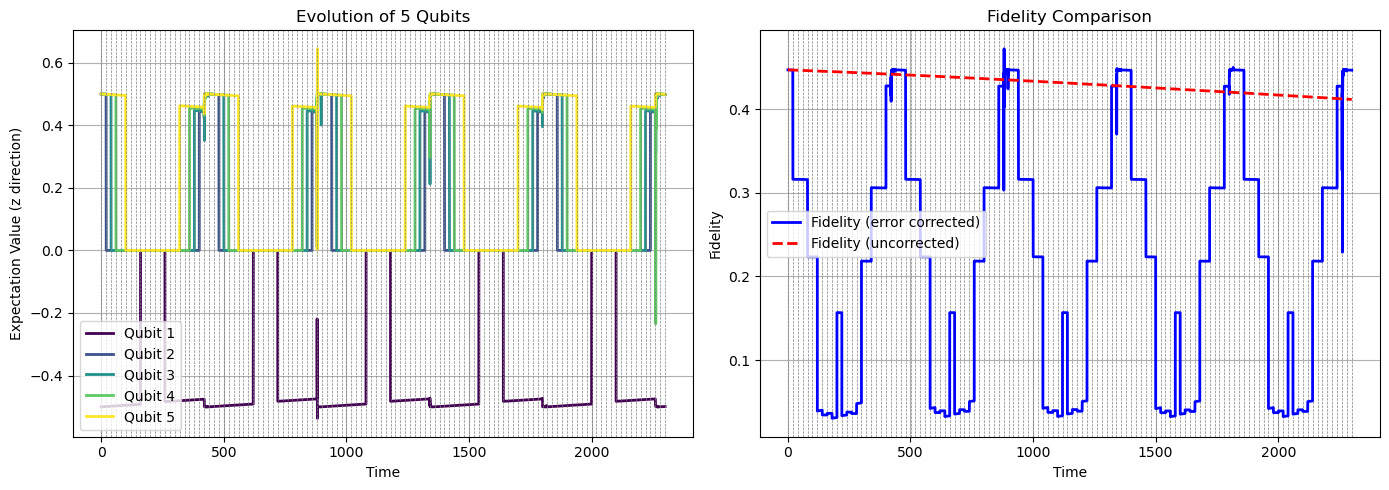

Total run time:   0.16s
syndrom measurement: 0001 applied correction: []


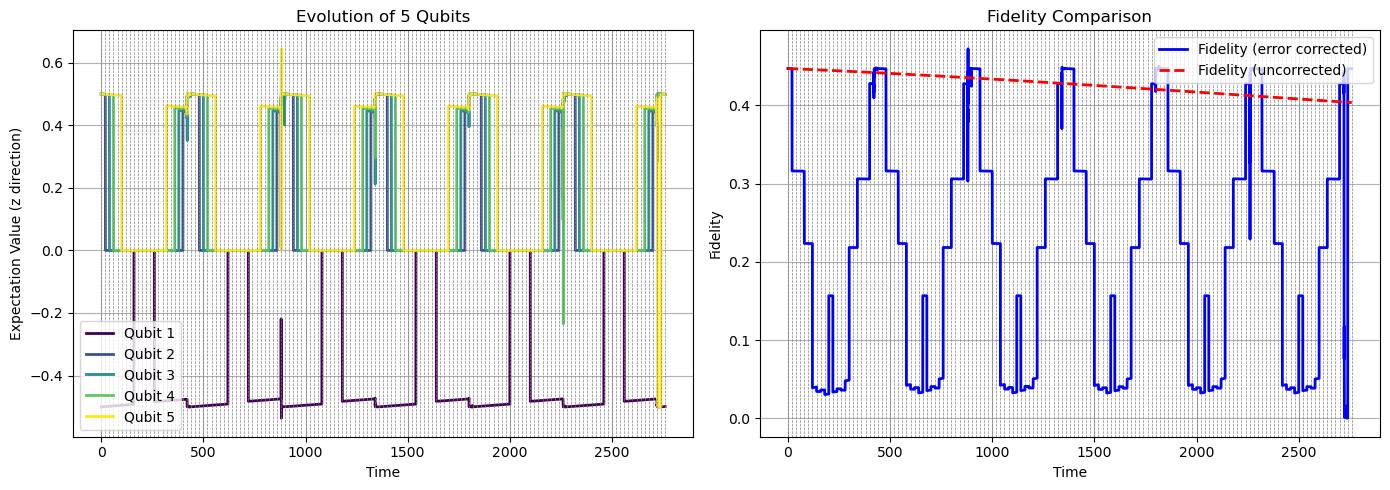

Total run time:   0.14s
syndrom measurement: 0000 applied correction: []


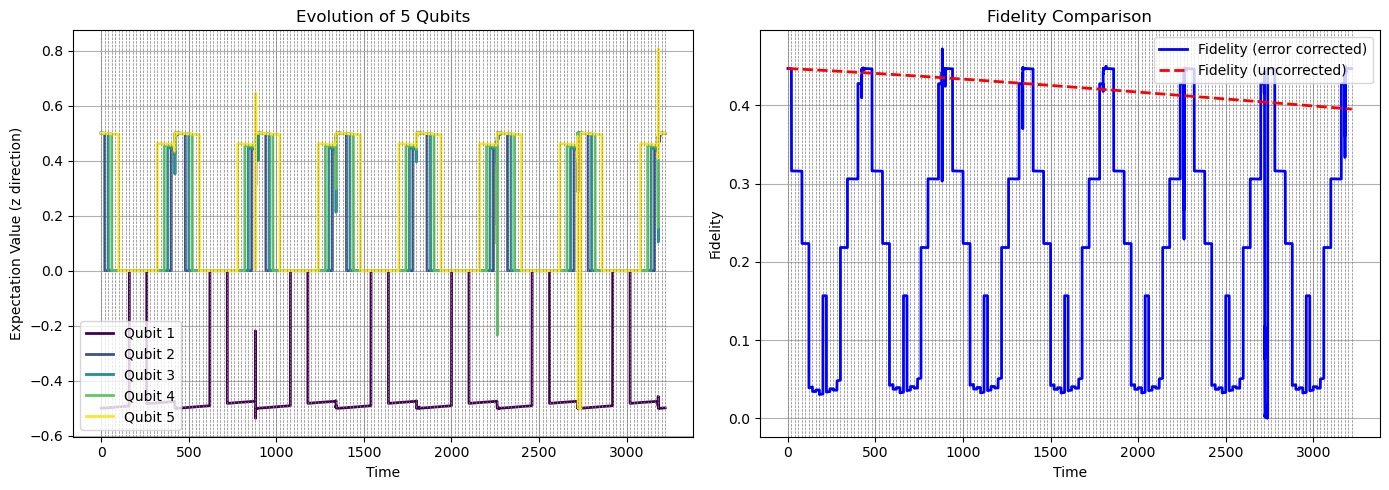

Total run time:   0.17s
syndrom measurement: 0000 applied correction: []


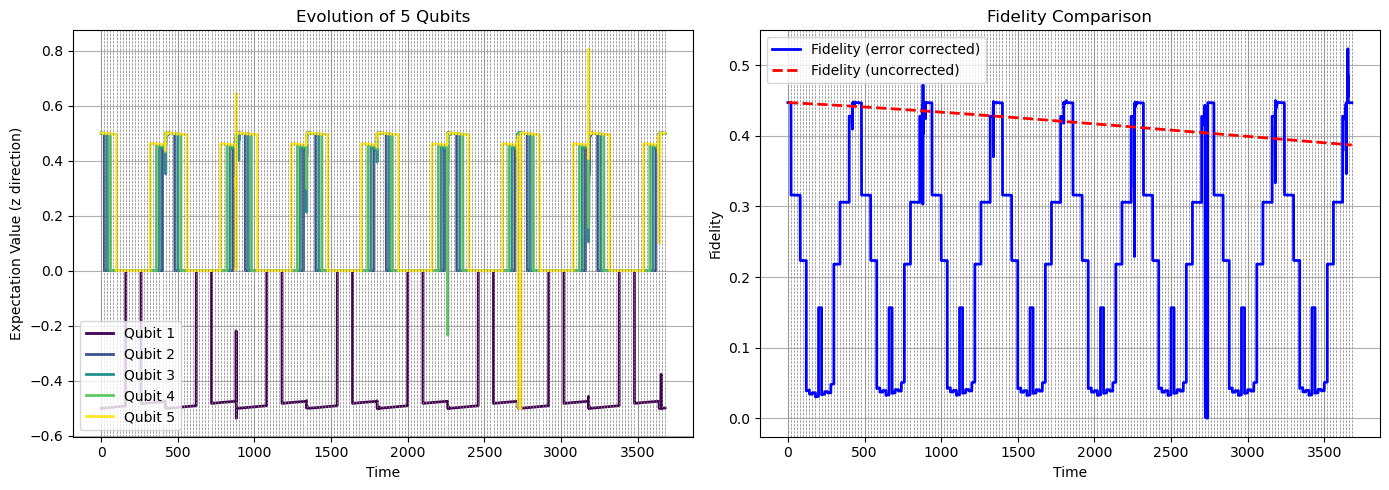

Total run time:   0.14s
syndrom measurement: 0001 applied correction: []


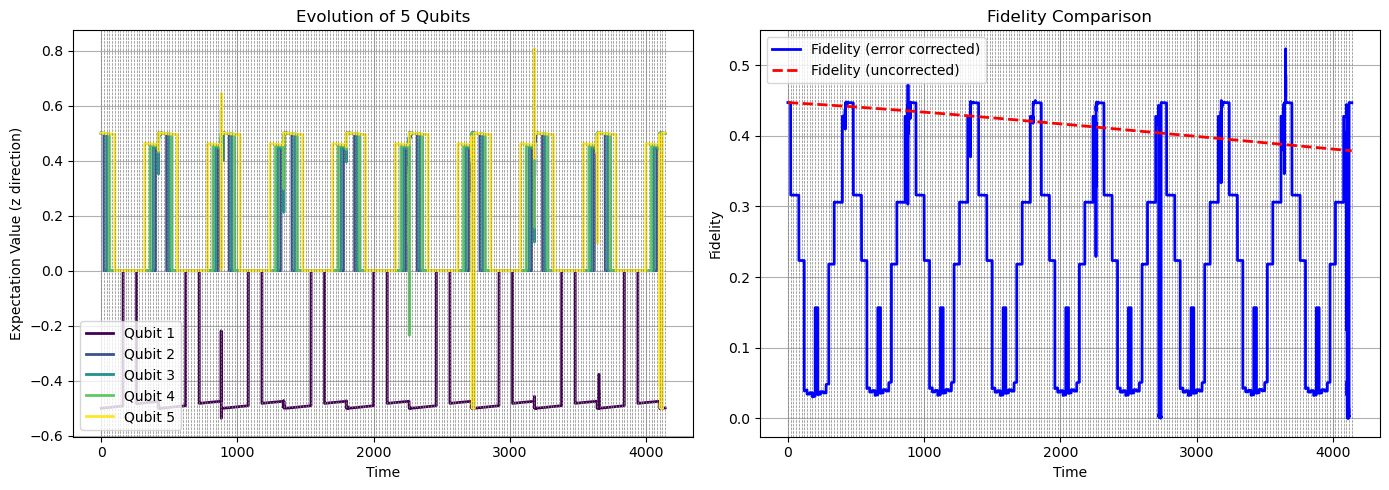

Total run time:   0.14s
syndrom measurement: 0000 applied correction: []


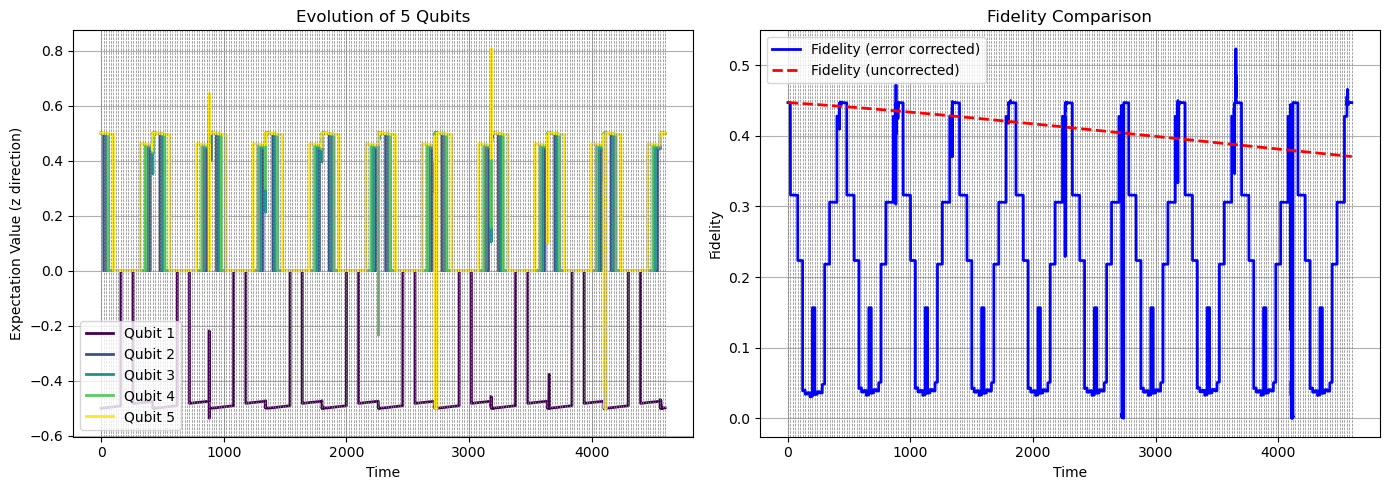

In [220]:
all_expect = {}

for i in range(n_qubits):
    all_expect[f'z_spin_{i+1}'] = np.array([])
    
all_t = np.array([])
all_rho = []
all_rho_test = []

rho = rho_0
rho_test = rho_0
n_cycles = 10

for _ in range(n_cycles):
    
    # Evlution of the error corrected qubit
    
    ## encoding, decoding
    rho, all_t, all_expect, all_rho = encoder(rho, all_t, all_expect, all_rho, rho_0)
    rho, all_t, all_expect, all_rho = decoder(rho, all_t, all_expect, all_rho, rho_0)

    ## measure anchillas
    c_ops_m = [c_measure_strength[op] * c_ops[op] for op in c_ops]
    sc_ops_m = [sc_measure_strength[op] * sc_ops[op] for op in sc_ops]
    opts = Options(store_states=True, store_final_state=True)

    result = smesolve(H, rho, t, c_ops=c_ops_m, sc_ops=sc_ops_m, e_ops=e_ops, options=opts)
    
    all_t, all_expect = store_result(all_t, all_expect, t, result)
    rho = result.states[0][-1]
    all_rho += result.states[0]

    ## correct error
    m2 = 0 if np.mean(all_expect['z_spin_2'][-10:])>0 else 1 
    m3 = 0 if np.mean(all_expect['z_spin_3'][-10:])>0 else 1 
    m4 = 0 if np.mean(all_expect['z_spin_4'][-10:])>0 else 1 
    m5 = 0 if np.mean(all_expect['z_spin_5'][-10:])>0 else 1 

    syndrom = str(m2) + str(m3) + str(m4) + str(m5)
    correction = correction_table[syndrom]
    corr_to_op = {'X': x_spin_1, 'Z': z_spin_1}
    
    print('syndrom measurement:', syndrom, 'applied correction:', correction)

    for op in correction:
        rho = dens_op(corr_to_op[op], rho)

    for i, state in enumerate(syndrom):
        if state==str(1):
            rho = dens_op(qip.operations.x_gate(N=5, target=i+1), rho)

    result = free_evo(rho, t)
    
    all_t, all_expect = store_result(all_t, all_expect, t, result)
    all_rho += result.states
    
    # Evolution of a uncorrected qubit for a comparison
    
    for _ in range(23):
        result_test = free_evo(rho_test, t)
        if len(all_rho_test) == 0:
            all_rho_test = result_test.states
        else: 
            all_rho_test += result_test.states
        rho_test = result_test.final_state
    
    plt_result(all_t, all_expect, all_rho, all_rho_test, psi_0, t_stop, n_steps)
    rho = result.final_state

# Results

During each cycle of encoding and decoding, the fidelity decreases as expected, since the encoded state is distant from the initial state `psi_0` in Hilbert space. However, after decoding and correcting the ancilla and main qubit, the fidelity returns to approximately its maximum value. In contrast, the fidelity of the uncorrected qubit decays significantly over the course of the simulation.